<a href="https://colab.research.google.com/github/Palak-bansal-26/Natural-Disaster-Prediction/blob/main/Earthquake_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the Dependencies**

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [47]:
earthquake_data = pd.read_csv('/content/Earthquake_Data.csv')

In [48]:
earthquake_data.head()

,Date(YYYY/MM/DD) Time Latitude Longitude Depth Mag Magt Nst Gap Clo RMS SRC EventID
0,1966/07/01 09:41:21.82 35.9463 -120.4700 12....
1,1966/07/02 12:08:34.25 35.7867 -120.3265 8....
2,1966/07/02 12:16:14.95 35.7928 -120.3353 9....
3,1966/07/02 12:25:06.12 35.7970 -120.3282 9....
4,1966/07/05 18:54:54.36 35.9223 -120.4585 7....


In [49]:
earthquake_data = earthquake_data.iloc[:, 0].str.split(expand=True)

# Assigning proper column names (assuming the original column names)
earthquake_data.columns = [
    'Date(YYYY/MM/DD)', 'Time', 'Latitude', 'Longitude', 'Depth', 'Mag',
    'Magt', 'Nst', 'Gap', 'Clo', 'RMS', 'SRC', 'EventID'
]
earthquake_data.head()

,Date(YYYY/MM/DD),Time,Latitude,Longitude,Depth,Mag,Magt,Nst,Gap,Clo,RMS,SRC,EventID
0,1966/07/01,09:41:21.82,35.9463,-120.4700,12.26,3.20,Mx,7,171,20,0.02,NCSN,-4540462
1,1966/07/02,12:08:34.25,35.7867,-120.3265,8.99,3.70,Mx,8,86,3,0.04,NCSN,-4540520
2,1966/07/02,12:16:14.95,35.7928,-120.3353,9.88,3.40,Mx,8,89,2,0.03,NCSN,-4540521
3,1966/07/02,12:25:06.12,35.7970,-120.3282,9.09,3.10,Mx,8,101,3,0.08,NCSN,-4540522
4,1966/07/05,18:54:54.36,35.9223,-120.4585,7.86,3.10,Mx,9,161,14,0.04,NCSN,-4540594


In [50]:
earthquake_data.shape

(18030, 13)

In [51]:
earthquake_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18030 entries, 0 to 18029
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Date(YYYY/MM/DD)  18030 non-null  object
 1   Time              18030 non-null  object
 2   Latitude          18030 non-null  object
 3   Longitude         18030 non-null  object
 4   Depth             18030 non-null  object
 5   Mag               18030 non-null  object
 6   Magt              18030 non-null  object
 7   Nst               18030 non-null  object
 8   Gap               18030 non-null  object
 9   Clo               18030 non-null  object
 10  RMS               18030 non-null  object
 11  SRC               18030 non-null  object
 12  EventID           18030 non-null  object
dtypes: object(13)
memory usage: 1.8+ MB


In [52]:
earthquake_data.isnull().sum()

,0
Date(YYYY/MM/DD),0
Time,0
Latitude,0
Longitude,0
Depth,0
Mag,0
Magt,0
Nst,0
Gap,0
Clo,0


In [53]:
earthquake_data.describe()

,Date(YYYY/MM/DD),Time,Latitude,Longitude,Depth,Mag,Magt,Nst,Gap,Clo,RMS,SRC,EventID
count,18030,18030,18030,18030,18030,18030,18030,18030,18030,18030,18030,18030,18030
unique,8138,18012,12408,13301,2856,255,4,187,337,268,202,1,18030
top,1983/05/03,05:55:14.88,37.6380,-118.8727,5.00,3.00,Md,13,39,3,0.06,NCSN,-4540462
freq,144,2,14,8,388,926,12353,541,159,1437,2201,18030,1


In [54]:
earthquake_data.nunique()

,0
Date(YYYY/MM/DD),8138
Time,18012
Latitude,12408
Longitude,13301
Depth,2856
Mag,255
Magt,4
Nst,187
Gap,337
Clo,268


**Data Preprocessing**

In [55]:
earthquake_data = earthquake_data.drop_duplicates()

In [56]:
# Convert the 'Depth' column to numeric, coercing errors to NaN (to handle any non-numeric values)
earthquake_data['Depth'] = pd.to_numeric(earthquake_data['Depth'], errors='coerce')

# Drop rows where 'Depth' could not be converted to a numeric type (optional, if such rows exist)
earthquake_data = earthquake_data.dropna(subset=['Depth'])

# Outlier detection (Example: Remove extreme outliers)
earthquake_data = earthquake_data[(np.abs(earthquake_data['Depth'] - earthquake_data['Depth'].mean()) <= (3*earthquake_data['Depth'].std()))]



In [57]:
# Normalization/Standardization
scaler = StandardScaler()
scaled_features = scaler.fit_transform(earthquake_data[['Latitude', 'Longitude', 'Depth', 'Mag']])


In [58]:
# Encoding categorical variables (Example: One-hot encoding)
earthquake_data = pd.get_dummies(earthquake_data, columns=['Magt', 'SRC'])


In [59]:
# Split the data
X = earthquake_data.drop(columns=['EventID', 'Date(YYYY/MM/DD)', 'Time'])
y = earthquake_data['Mag']  # Example target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [60]:
# Step 12: Correlation analysis
correlation_matrix = X_train.corr()
print("Correlation matrix:\n", correlation_matrix)


Correlation matrix:
            Latitude  Longitude     Depth       Mag       Nst       Gap  \
Latitude   1.000000  -0.680920  0.174371 -0.052868 -0.021406  0.241901   
Longitude -0.680920   1.000000 -0.205399  0.045049 -0.133132 -0.105817   
Depth      0.174371  -0.205399  1.000000  0.029897 -0.087758  0.171915   
Mag       -0.052868   0.045049  0.029897  1.000000  0.177118  0.062917   
Nst       -0.021406  -0.133132 -0.087758  0.177118  1.000000 -0.357173   
Gap        0.241901  -0.105817  0.171915  0.062917 -0.357173  1.000000   
Clo        0.224372  -0.148981 -0.019263  0.108920 -0.044000  0.660899   
RMS        0.022004   0.011881 -0.024953  0.029889  0.014493  0.061822   
Magt_ML    0.142500  -0.135421  0.059971  0.175945  0.238765 -0.127132   
Magt_Md   -0.141501   0.136482 -0.058772 -0.194284 -0.246273  0.127080   
Magt_Mw    0.013514  -0.026073 -0.013153  0.134931  0.096664 -0.046457   
Magt_Mx   -0.013256   0.012740  0.009238 -0.006409 -0.037497  0.042956   
SRC_NCSN        N

In [61]:
#  Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
principal_components = pca.fit_transform(scaled_features)





In [62]:
# After PCA, the transformed dataset is now in 'principal_components'
print("Shape of data after PCA:", principal_components.shape)


Shape of data after PCA: (17779, 4)


In [63]:
print(X_train, X_test, y_train, y_test)

      Latitude  Longitude  Depth   Mag Nst  Gap Clo   RMS  Magt_ML  Magt_Md  \
14651  37.1392  -118.2400  12.31  3.07  38  180  25  0.07    False     True   
14546  38.7912  -122.7542   3.53  3.22  47   31   4  0.07    False     True   
589    36.6442  -121.2587   7.31  3.79  25   61   3  0.07    False     True   
15013  40.6315  -121.1780   0.04  3.10  28  192  30  0.21    False     True   
11065  39.2738  -119.6898   0.11  3.00  24  280  99  0.14     True    False   
...        ...        ...    ...   ...  ..  ...  ..   ...      ...      ...   
11439  40.1768  -121.4958  10.17  3.00  34  102   4  0.11    False     True   
12135  40.3112  -124.4580  19.38  3.17  20  240  15  0.05    False     True   
5443   37.6462  -118.9348   6.38  3.09   5  232   9  0.06    False     True   
863    36.6938  -121.3268   4.38  3.91  12   95   2  0.05    False     True   
16020  38.2425  -119.4060  10.63  3.06  48   87  28  0.11    False     True   

       Magt_Mw  Magt_Mx  SRC_NCSN  
14651    False 

**Training Models**

**Linear Regression**

In [64]:

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions with the trained model
y_pred_lr = lr_model.predict(X_test)

# Ensure that y_test and y_pred_lr are numeric
y_test_numeric = pd.to_numeric(y_test, errors='coerce')
y_pred_numeric = pd.to_numeric(y_pred_lr, errors='coerce')

# Evaluation
mse_lr = mean_squared_error(y_test_numeric, y_pred_numeric)
r2_lr = r2_score(y_test_numeric, y_pred_numeric)
print(f"Linear Regression - MSE: {mse_lr}, R²: {r2_lr}")

# Discretize (round) the predicted and actual values for accuracy calculation
y_pred_discretized = np.round(y_pred_numeric)
y_test_discretized = np.round(y_test_numeric)

# Calculate accuracy
accuracy = accuracy_score(y_test_discretized, y_pred_discretized)
print(f"Linear Regression - Accuracy: {accuracy * 100:.2f}%")


Linear Regression - MSE: 1.1374316079350572e-29, R²: 1.0
Linear Regression - Accuracy: 98.28%


**Random Forest Regressor**

In [65]:
# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - MSE: {mse_rf}, R²: {r2_rf}")

# Ensure that y_test and y_pred_rf are numeric
y_test_numeric = pd.to_numeric(y_test, errors='coerce')
y_pred_numeric = pd.to_numeric(y_pred_rf, errors='coerce')

# Discretize (round) the predicted and actual values for accuracy calculation
y_pred_discretized = np.round(y_pred_numeric)
y_test_discretized = np.round(y_test_numeric)

# Calculate accuracy
accuracy = accuracy_score(y_test_discretized, y_pred_discretized)
print(f"Random Forest - Accuracy: {accuracy * 100:.2f}%")


Random Forest - MSE: 1.8230728346456907e-05, R²: 0.999908621499605
Random Forest - Accuracy: 99.97%


**Support Vector Regressor**

In [66]:
# Support Vector Regressor
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)

# Evaluation
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print(f"SVR - MSE: {mse_svr}, R²: {r2_svr}")

# Ensure that y_test and y_pred_svr are numeric
y_test_numeric = pd.to_numeric(y_test, errors='coerce')
y_pred_numeric = pd.to_numeric(y_pred_svr, errors='coerce')

# Discretize (round) the predicted and actual values for accuracy calculation
y_pred_discretized = np.round(y_pred_numeric)
y_test_discretized = np.round(y_test_numeric)

# Calculate accuracy
accuracy = accuracy_score(y_test_discretized, y_pred_discretized)
print(f"SVR - Accuracy: {accuracy * 100:.2f}%")


SVR - MSE: 0.1472349730278026, R²: 0.2620091317640224
SVR - Accuracy: 69.52%


**Gradient Boosting Regressor**

In [67]:
# Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)

# Evaluation
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)
print(f"Gradient Boosting - MSE: {mse_gbr}, R²: {r2_gbr}")

# Ensure that y_test and y_pred_gbr are numeric
y_test_numeric = pd.to_numeric(y_test, errors='coerce')
y_pred_numeric = pd.to_numeric(y_pred_gbr, errors='coerce')

# Discretize (round) the predicted and actual values for accuracy calculation
y_pred_discretized = np.round(y_pred_numeric)
y_test_discretized = np.round(y_test_numeric)

# Calculate accuracy
accuracy = accuracy_score(y_test_discretized, y_pred_discretized)
print(f"Gradient Boosting - Accuracy: {accuracy * 100:.2f}%")


Gradient Boosting - MSE: 1.4402272180621273e-05, R²: 0.999927811000793
Gradient Boosting - Accuracy: 97.10%


**Comparing Model Performance**

Text(0.5, 0, 'MSE')

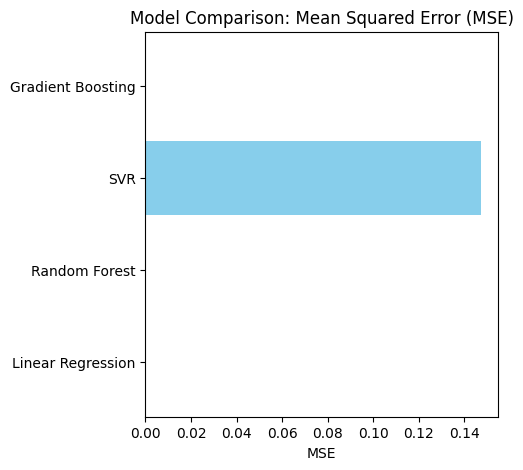

In [68]:
# Comparing Model Performance
models = ['Linear Regression', 'Random Forest', 'SVR', 'Gradient Boosting']
mse_values = [mse_lr, mse_rf, mse_svr, mse_gbr]
r2_values = [r2_lr, r2_rf, r2_svr, r2_gbr]

# Plotting MSE Comparison
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.barh(models, mse_values, color='skyblue')
plt.title('Model Comparison: Mean Squared Error (MSE)')
plt.xlabel('MSE')


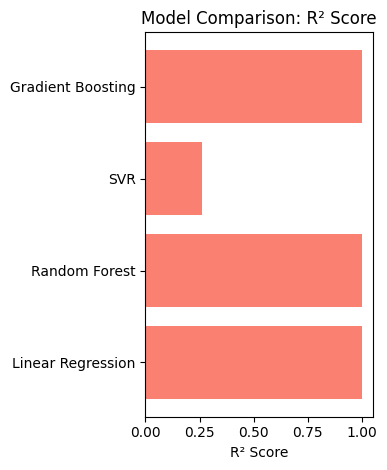

In [69]:
# Plotting R² Comparison
plt.subplot(1, 2, 2)
plt.barh(models, r2_values, color='salmon')
plt.title('Model Comparison: R² Score')
plt.xlabel('R² Score')

plt.tight_layout()
plt.show()


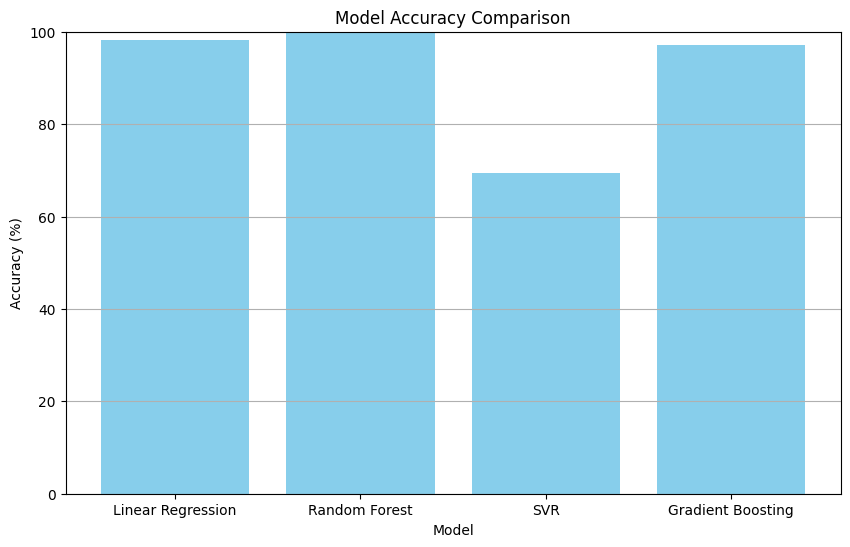

In [70]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR(kernel='rbf'),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Dictionary to store accuracy values
accuracy_scores = {}

for name, model in models.items():
    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Ensure y_test and y_pred are numeric
    y_test_numeric = pd.to_numeric(y_test, errors='coerce')
    y_pred_numeric = pd.to_numeric(y_pred, errors='coerce')

    # Discretize (round) the predicted and actual values
    y_pred_discretized = np.round(y_pred_numeric)
    y_test_discretized = np.round(y_test_numeric)

    # Calculate accuracy
    accuracy = accuracy_score(y_test_discretized, y_pred_discretized)
    accuracy_scores[name] = accuracy * 100  # Convert to percentage

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 100)  # Assuming accuracy is in percentage
plt.grid(axis='y')

# Display the plot
plt.show()
